# **0. Load Preliminary Functions**

## a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pickle
import itertools
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## b. MNIST Data Loader

In [2]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
		transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Unconditional GAN**


## a. Training Function for Discriminator

In [3]:
criterion = nn.BCELoss()

def train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels):
    discriminator.zero_grad()
    if with_condition:
      outputs = discriminator(images, cls_labels)
    else:
      outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.view(-1, 1))
    real_score = outputs

    if with_condition:
      outputs = discriminator(fake_images, cls_labels)
    else:
      outputs = discriminator(fake_images)

    fake_loss = criterion(outputs, fake_labels.view(-1, 1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score, fake_loss

## b. Training Function for Generator

In [4]:
def train_generator(generator, g_optimizer, discriminator_outputs, real_labels, with_condition):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.view(-1, 1))
    g_loss_fake = criterion(discriminator_outputs, 1 - real_labels.view(-1, 1))
    g_loss.backward()
    g_optimizer.step()
    return g_loss, g_loss_fake

## c. Monitors for Images and Losses


In [5]:
def monitor_images(generator, test_noise, with_condition):
    num_test_samples = test_noise.shape[0]
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)

    if with_condition:
      cls_labels = torch.randint(0, 10, (num_test_samples,)).to(device)
      test_images = generator(test_noise, label = cls_labels)
    else:
      test_images = generator(test_noise)

    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        if with_condition:
            ax[i, j].set_title(f'Class: {cls_labels[k].item()}', fontsize=10)
    plt.show()


def monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake):
    def moving_average(x, win=100):
        return np.convolve(x, np.ones(win), 'same') / np.convolve(np.ones_like(x), np.ones(win), 'same')

    plt.figure(figsize=(10, 5))
    iters = np.arange(len(d_losses))
    epochs = iters * batch_size / 60000
    plt.plot(epochs, moving_average(d_losses), label='d_loss')
    plt.plot(epochs, moving_average(g_losses), label='g_loss')
    plt.plot(epochs, moving_average(d_losses_fake), label='d_loss_fake')
    plt.plot(epochs, moving_average(g_losses_fake), label='g_loss_fake')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


## d. Model for Discriminator

In [15]:
class Discriminator(nn.Module):
    def __init__(self, channels = [512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(784 + (10 if with_condition else 0), channels[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(channels[2], 1),
            nn.Sigmoid() # Output probability
        )
        ##################
        ### Problem 1: Implement Discriminator
        ##################

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
          assert label is not None
          ##################
          ### Problem 3: Implement Conditional GAN
          ##################
          c = self.label_embedding(label)
          x = torch.cat([x, c], 1)
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out

## e. Model for Generator


In [16]:
class Generator(nn.Module):
    def __init__(self, dim_z=100, channels = [128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(dim_z + (10 if with_condition else 0), channels[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(channels[2], 784),
            nn.Tanh() # Output pixel values in the range [-1, 1]
        )
        ##################
        ### Problem 1: Implement Generator
        ##################

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)

        if self.with_condition:
          assert label is not None
          ##################
          ### Problem 3: Implement Conditional GAN
          ##################
          c = self.label_embedding(label)
          x = torch.cat([x, c], 1)
        out = self.model(x)
        return out

## d. Train

In [8]:
num_batches = len(train_loader)

def train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise,
                    num_epochs, d_freq, with_condition):
  d_losses = []
  g_losses = []
  d_losses_fake = []
  g_losses_fake = []
  for epoch in range(num_epochs):
      for n, (images, cls_labels) in enumerate(train_loader):
          images = Variable(images.to(device))
          real_labels = Variable(torch.ones(images.size(0)).to(device))
          cls_labels = cls_labels.to(device)

          # Sample from generator
          noise = Variable(torch.randn(images.size(0), dim_z).to(device))
          fake_images = generator(noise, label=cls_labels if with_condition else None)
          fake_labels = Variable(torch.zeros(images.size(0)).to(device))

          # Train the discriminator
          d_loss, real_score, fake_score, d_loss_fake = train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels=cls_labels)

          if n % d_freq == 0:
            # Sample again from the generator and get output from discriminator
            noise = Variable(torch.randn(images.size(0), dim_z).to(device))
            fake_images = generator(noise, label=cls_labels if with_condition else None)
            outputs = discriminator(fake_images, label=cls_labels if with_condition else None)

            # Train the generator
            g_loss, g_loss_fake = train_generator(generator, g_optimizer, outputs, real_labels, with_condition)

          d_losses.append(d_loss.data.detach().cpu().numpy())
          g_losses.append(g_loss.data.detach().cpu().numpy())
          d_losses_fake.append(d_loss_fake.data.detach().cpu().numpy())
          g_losses_fake.append(g_loss_fake.data.detach().cpu().numpy())

          if (n+1) == num_batches:
              print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, d_loss_fake: %.4f, g_loss: %.4f, g_loss_fake: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, d_loss_fake.data, g_loss.data, g_loss_fake.data,
                      real_score.data.mean(), fake_score.data.mean()))
      if epoch == num_epochs - 1:
          monitor_images(generator, test_noise, with_condition=with_condition)
          monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)
  return d_losses, d_losses_fake, g_losses, g_losses_fake

Epoch [1/200], Step[469/469], d_loss: 1.1455, d_loss_fake: 0.5012, g_loss: 1.1980, g_loss_fake: 0.4397, D(x): 0.59, D(G(z)): 0.37
Epoch [2/200], Step[469/469], d_loss: 0.7880, d_loss_fake: 0.4925, g_loss: 1.7089, g_loss_fake: 0.3077, D(x): 0.77, D(G(z)): 0.36
Epoch [3/200], Step[469/469], d_loss: 0.4993, d_loss_fake: 0.2831, g_loss: 3.0981, g_loss_fake: 0.1309, D(x): 0.83, D(G(z)): 0.23
Epoch [4/200], Step[469/469], d_loss: 0.3183, d_loss_fake: 0.1566, g_loss: 3.1372, g_loss_fake: 0.1340, D(x): 0.88, D(G(z)): 0.13
Epoch [5/200], Step[469/469], d_loss: 0.1840, d_loss_fake: 0.1136, g_loss: 3.4131, g_loss_fake: 0.0629, D(x): 0.95, D(G(z)): 0.09
Epoch [6/200], Step[469/469], d_loss: 0.5113, d_loss_fake: 0.1531, g_loss: 2.9745, g_loss_fake: 0.0906, D(x): 0.81, D(G(z)): 0.12
Epoch [7/200], Step[469/469], d_loss: 0.1890, d_loss_fake: 0.0677, g_loss: 3.7727, g_loss_fake: 0.0694, D(x): 0.92, D(G(z)): 0.06
Epoch [8/200], Step[469/469], d_loss: 0.6071, d_loss_fake: 0.2854, g_loss: 3.1525, g_loss_

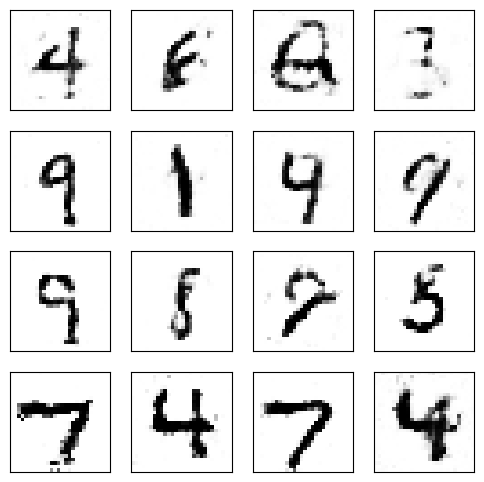

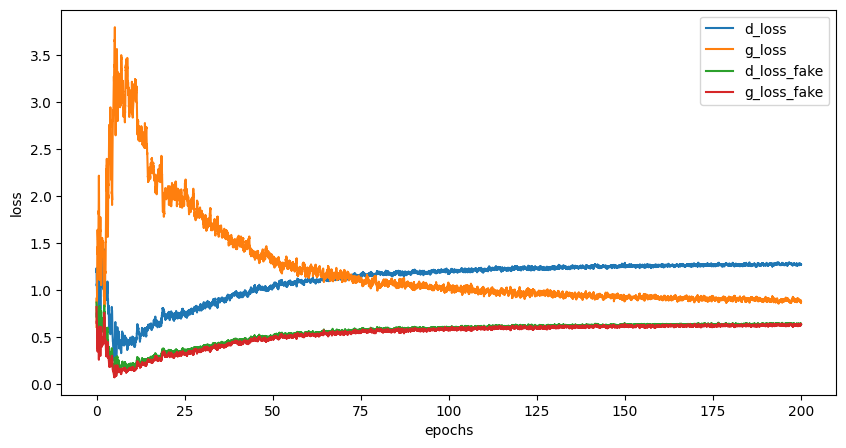

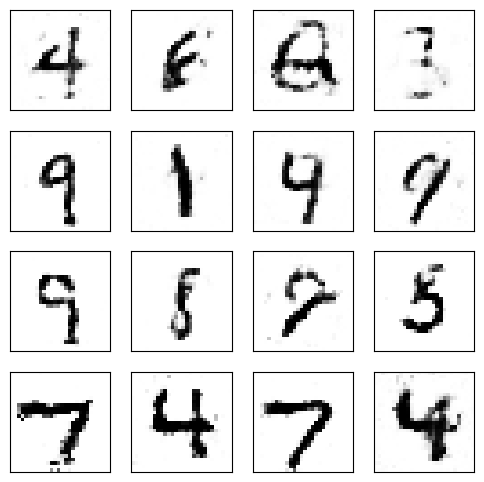

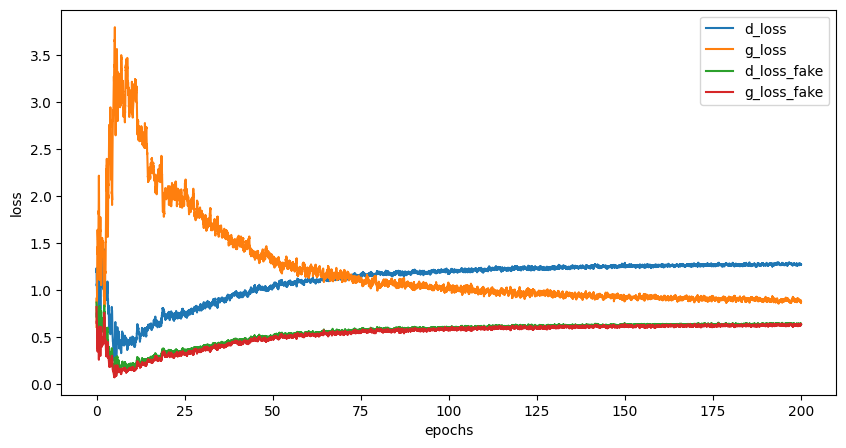

In [9]:
# set number of epochs and initialize figure counter
num_epochs = 200
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 2e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

## e. Ablation Study

Epoch [1/150], Step[469/469], d_loss: 0.7138, d_loss_fake: 0.6509, g_loss: 3.3060, g_loss_fake: 0.0788, D(x): 0.94, D(G(z)): 0.45
Epoch [2/150], Step[469/469], d_loss: 0.1852, d_loss_fake: 0.1374, g_loss: 5.7666, g_loss_fake: 0.0469, D(x): 0.96, D(G(z)): 0.08
Epoch [3/150], Step[469/469], d_loss: 0.9925, d_loss_fake: 0.3637, g_loss: 3.1808, g_loss_fake: 0.3517, D(x): 0.66, D(G(z)): 0.21
Epoch [4/150], Step[469/469], d_loss: 0.9740, d_loss_fake: 0.3093, g_loss: 2.4959, g_loss_fake: 0.2695, D(x): 0.69, D(G(z)): 0.22
Epoch [5/150], Step[469/469], d_loss: 0.8701, d_loss_fake: 0.4246, g_loss: 2.0281, g_loss_fake: 0.2687, D(x): 0.76, D(G(z)): 0.31
Epoch [6/150], Step[469/469], d_loss: 0.5829, d_loss_fake: 0.2778, g_loss: 2.6163, g_loss_fake: 0.1378, D(x): 0.84, D(G(z)): 0.17
Epoch [7/150], Step[469/469], d_loss: 0.4039, d_loss_fake: 0.1270, g_loss: 3.5072, g_loss_fake: 0.0707, D(x): 0.87, D(G(z)): 0.11
Epoch [8/150], Step[469/469], d_loss: 0.8866, d_loss_fake: 0.4522, g_loss: 2.1539, g_loss_

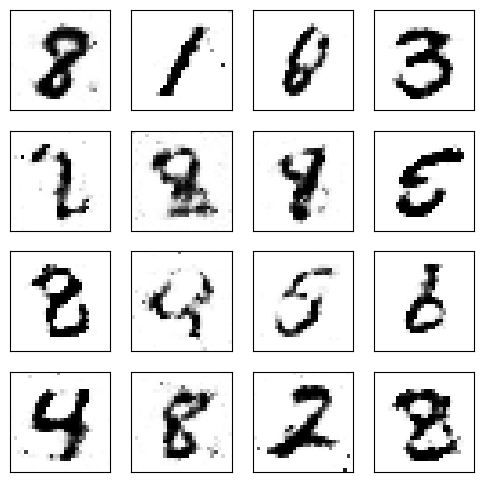

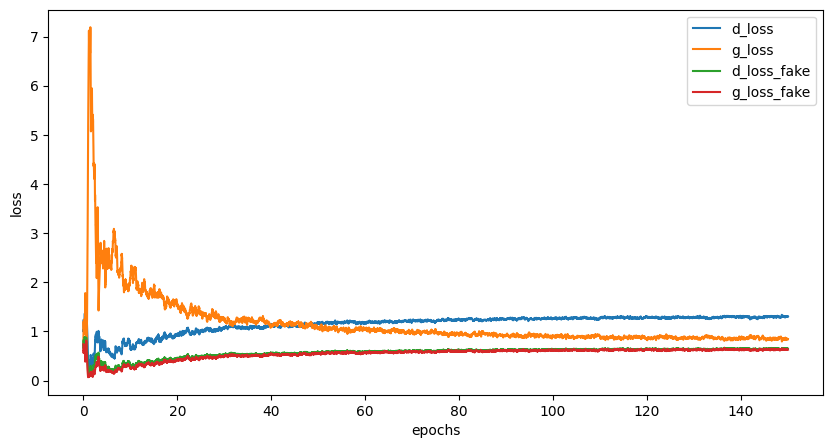

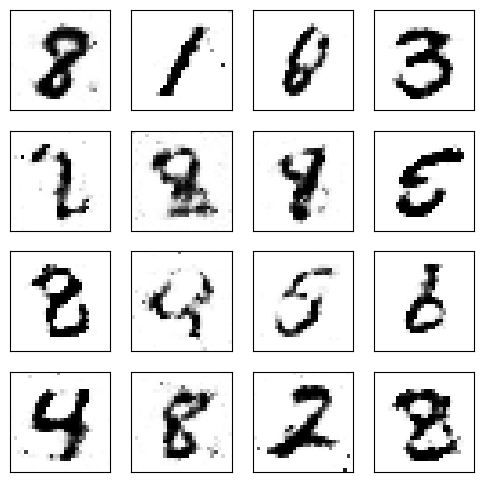

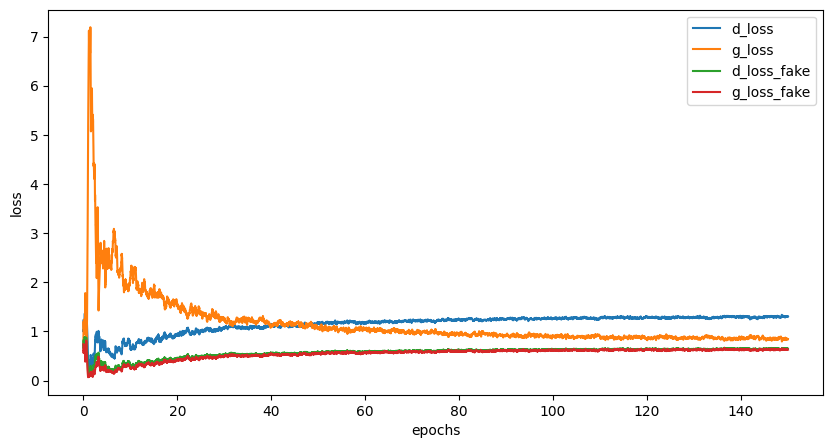

In [11]:
##################
### Problem 2: Ablation study 1, 2, and 3
##################
# experiment 1. Double the size of the channels in generator
class GeneratorExp1(nn.Module):
    def __init__(self, dim_z=100, channels = [256, 512, 1024], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = nn.Sequential(
            nn.Linear(dim_z, channels[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[2], 784),
            nn.Tanh()
        )

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)
        if self.with_condition:
          pass
        out = self.model(x)
        return out

class DiscriminatorExp1(nn.Module):
    def __init__(self, channels = [512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = nn.Sequential(
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
          pass
        out = self.model(x)
        return out



generator_exp1 = GeneratorExp1(dim_z=dim_z).to(device)
discriminator_exp1 = DiscriminatorExp1().to(device)
g_optimizer_exp1 = torch.optim.Adam(generator_exp1.parameters(), lr=lr)
d_optimizer_exp1 = torch.optim.Adam(discriminator_exp1.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator_exp1, discriminator_exp1, d_optimizer_exp1, g_optimizer_exp1, test_noise, 150, 1, with_condition)
monitor_images(generator_exp1, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

Epoch [1/150], Step[469/469], d_loss: 1.2319, d_loss_fake: 0.6228, g_loss: 2.2230, g_loss_fake: 0.2069, D(x): 0.61, D(G(z)): 0.43
Epoch [2/150], Step[469/469], d_loss: 0.4068, d_loss_fake: 0.2090, g_loss: 3.4152, g_loss_fake: 0.1325, D(x): 0.84, D(G(z)): 0.16
Epoch [3/150], Step[469/469], d_loss: 0.5674, d_loss_fake: 0.2324, g_loss: 2.5112, g_loss_fake: 0.1885, D(x): 0.78, D(G(z)): 0.17
Epoch [4/150], Step[469/469], d_loss: 0.2629, d_loss_fake: 0.1552, g_loss: 2.8415, g_loss_fake: 0.1497, D(x): 0.93, D(G(z)): 0.12
Epoch [5/150], Step[469/469], d_loss: 0.3629, d_loss_fake: 0.2450, g_loss: 3.1587, g_loss_fake: 0.1937, D(x): 0.93, D(G(z)): 0.15
Epoch [6/150], Step[469/469], d_loss: 0.2220, d_loss_fake: 0.1685, g_loss: 3.5691, g_loss_fake: 0.0708, D(x): 0.97, D(G(z)): 0.12
Epoch [7/150], Step[469/469], d_loss: 0.6701, d_loss_fake: 0.2549, g_loss: 2.6327, g_loss_fake: 0.2446, D(x): 0.82, D(G(z)): 0.18
Epoch [8/150], Step[469/469], d_loss: 0.8715, d_loss_fake: 0.2023, g_loss: 2.7828, g_loss_

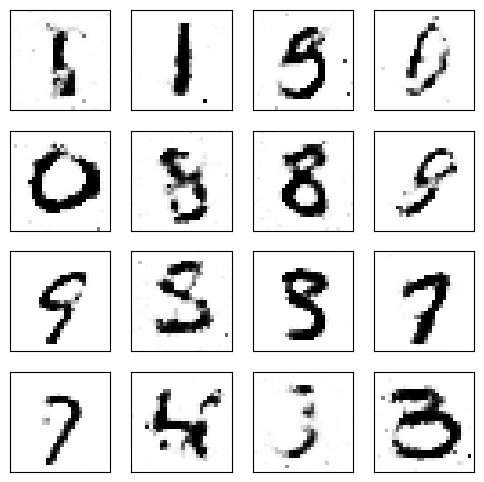

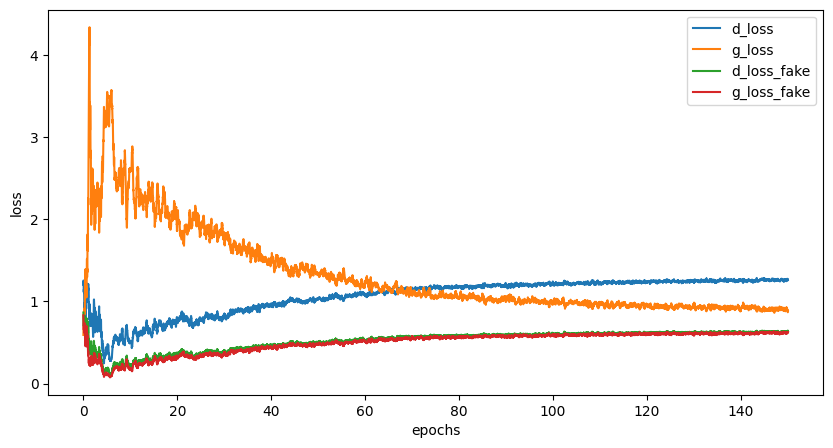

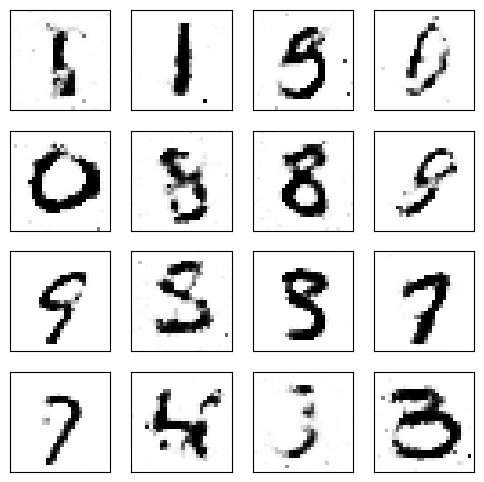

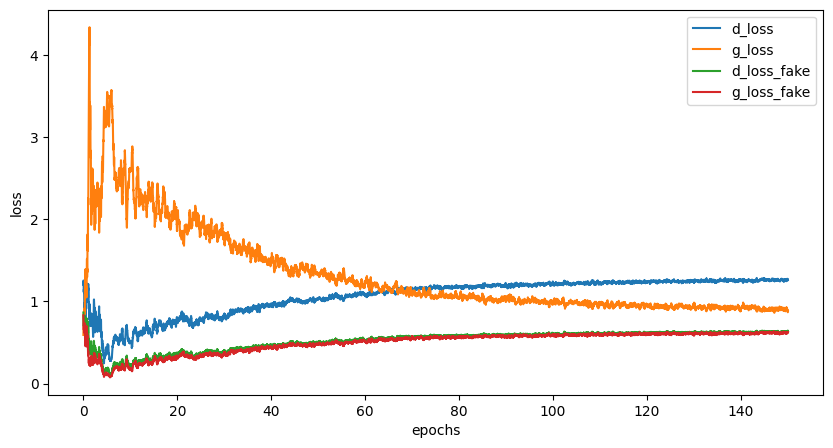

In [12]:
# experiment 2. Increase the capacity of the discriminator by increasing the number of layers.
class GeneratorExp2(nn.Module):
    def __init__(self, dim_z=100, channels = [128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = nn.Sequential(
            nn.Linear(dim_z, channels[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[2], 784),
            nn.Tanh()
        )

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)
        if self.with_condition:
          pass
        out = self.model(x)
        return out

class DiscriminatorExp2(nn.Module):
    def __init__(self, channels = [512, 256, 128, 64], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = nn.Sequential(
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[2], channels[3]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[3], 1),
            nn.Sigmoid()
        )

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
          pass
        out = self.model(x)
        return out

generator_exp2 = GeneratorExp2(dim_z=dim_z).to(device)
discriminator_exp2 = DiscriminatorExp2().to(device)
g_optimizer_exp2 = torch.optim.Adam(generator_exp2.parameters(), lr=lr)
d_optimizer_exp2 = torch.optim.Adam(discriminator_exp2.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator_exp2, discriminator_exp2, d_optimizer_exp2, g_optimizer_exp2, test_noise, 150, 1, with_condition)
monitor_images(generator_exp2, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

Epoch [1/150], Step[469/469], d_loss: 0.0003, d_loss_fake: 0.0003, g_loss: 9.0825, g_loss_fake: 0.0005, D(x): 1.00, D(G(z)): 0.00
Epoch [2/150], Step[469/469], d_loss: 0.0005, d_loss_fake: 0.0005, g_loss: 14.3525, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [3/150], Step[469/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 9.3920, g_loss_fake: 0.0047, D(x): 1.00, D(G(z)): 0.00
Epoch [4/150], Step[469/469], d_loss: 0.0002, d_loss_fake: 0.0000, g_loss: 14.2510, g_loss_fake: 0.0002, D(x): 1.00, D(G(z)): 0.00
Epoch [5/150], Step[469/469], d_loss: 0.0000, d_loss_fake: 0.0000, g_loss: 16.9769, g_loss_fake: 0.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [6/150], Step[469/469], d_loss: 0.0008, d_loss_fake: 0.0005, g_loss: 12.2858, g_loss_fake: 0.0001, D(x): 1.00, D(G(z)): 0.00
Epoch [7/150], Step[469/469], d_loss: 0.0002, d_loss_fake: 0.0000, g_loss: 10.6935, g_loss_fake: 0.0008, D(x): 1.00, D(G(z)): 0.00
Epoch [8/150], Step[469/469], d_loss: 0.0001, d_loss_fake: 0.0001, g_loss: 10.9177, g

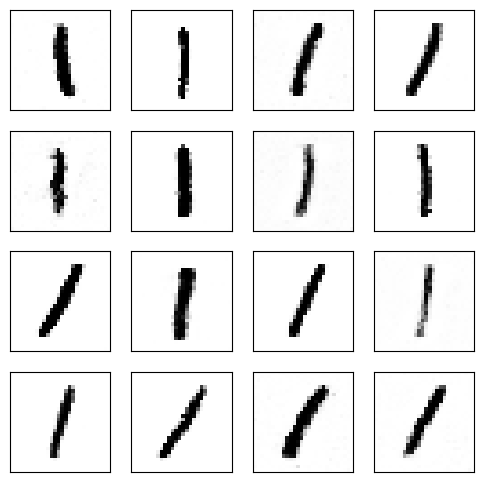

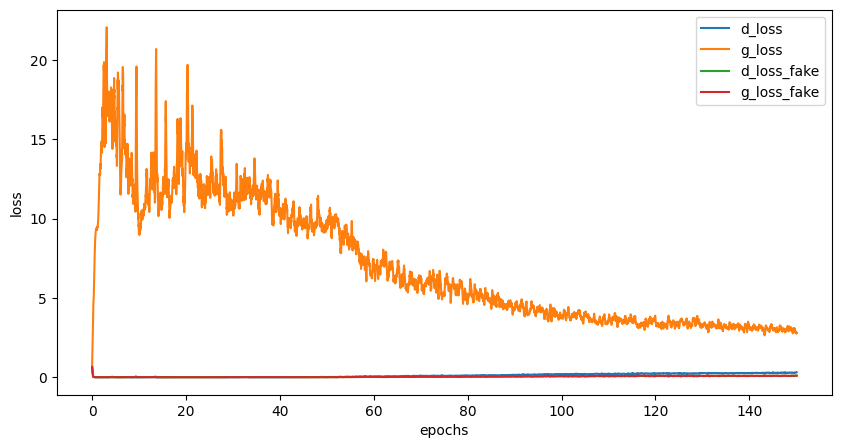

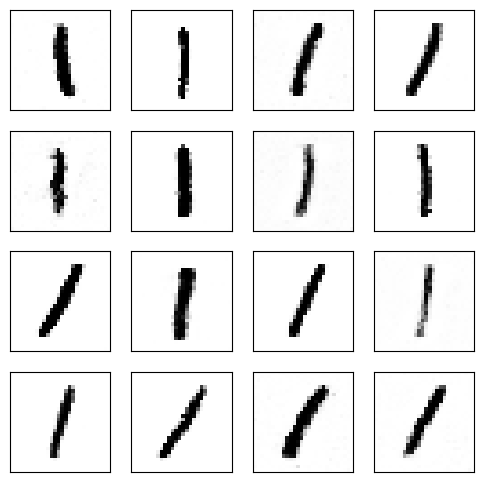

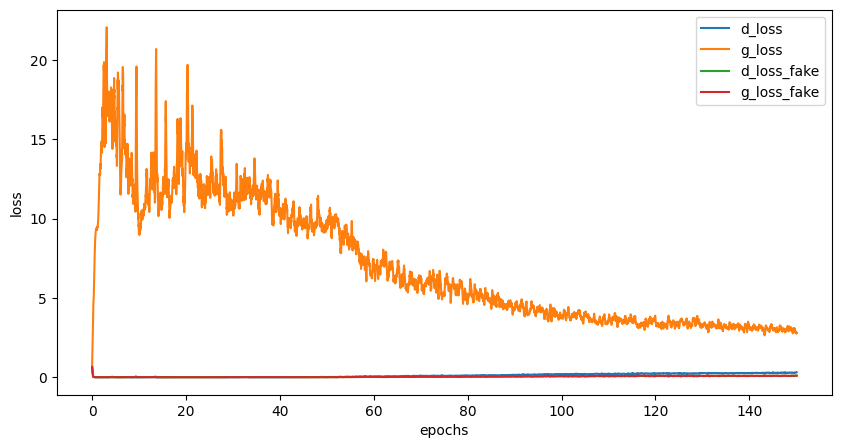

In [14]:
# experiment 3. Modify the training loop to update the discriminator 10 times for every 1 update of the generator.
class GeneratorExp3(nn.Module):
    def __init__(self, dim_z=100, channels = [128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = nn.Sequential(
            nn.Linear(dim_z, channels[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2),
            nn.Linear(channels[2], 784),
            nn.Tanh()
        )

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)
        if self.with_condition:
          pass
        out = self.model(x)
        return out

class DiscriminatorExp3(nn.Module):
    def __init__(self, channels = [512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = nn.Sequential(
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[0], channels[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[1], channels[2]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(channels[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
          pass
        out = self.model(x)
        return out


generator_exp3 = GeneratorExp3(dim_z=dim_z).to(device)
discriminator_exp3 = DiscriminatorExp3().to(device)
g_optimizer_exp3 = torch.optim.Adam(generator_exp3.parameters(), lr=lr)
d_optimizer_exp3 = torch.optim.Adam(discriminator_exp3.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator_exp3, discriminator_exp3, d_optimizer_exp3, g_optimizer_exp3, test_noise, 150, 10, with_condition)
monitor_images(generator_exp3, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# **2. Conditional GAN**

Epoch [1/150], Step[469/469], d_loss: 1.3258, d_loss_fake: 0.6886, g_loss: 0.9308, g_loss_fake: 0.6412, D(x): 0.57, D(G(z)): 0.47
Epoch [2/150], Step[469/469], d_loss: 1.4368, d_loss_fake: 0.7305, g_loss: 1.0628, g_loss_fake: 0.5646, D(x): 0.62, D(G(z)): 0.47
Epoch [3/150], Step[469/469], d_loss: 0.9613, d_loss_fake: 0.4543, g_loss: 1.5275, g_loss_fake: 0.3357, D(x): 0.66, D(G(z)): 0.34
Epoch [4/150], Step[469/469], d_loss: 1.1124, d_loss_fake: 0.4836, g_loss: 1.8069, g_loss_fake: 0.3045, D(x): 0.65, D(G(z)): 0.33
Epoch [5/150], Step[469/469], d_loss: 1.2150, d_loss_fake: 0.3728, g_loss: 1.7544, g_loss_fake: 0.3718, D(x): 0.58, D(G(z)): 0.27
Epoch [6/150], Step[469/469], d_loss: 1.0389, d_loss_fake: 0.5564, g_loss: 1.5726, g_loss_fake: 0.4654, D(x): 0.74, D(G(z)): 0.37
Epoch [7/150], Step[469/469], d_loss: 0.2902, d_loss_fake: 0.1369, g_loss: 2.3848, g_loss_fake: 0.1397, D(x): 0.91, D(G(z)): 0.12
Epoch [8/150], Step[469/469], d_loss: 0.5357, d_loss_fake: 0.1949, g_loss: 2.6654, g_loss_

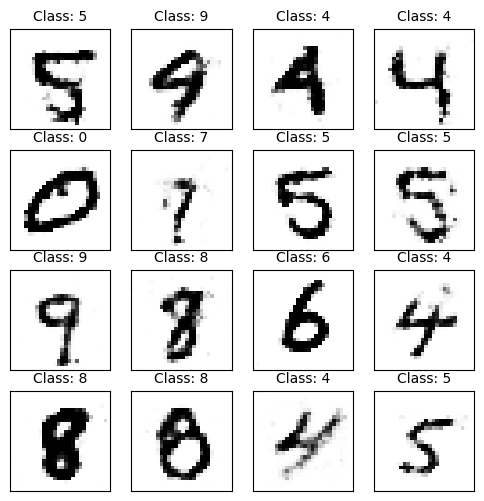

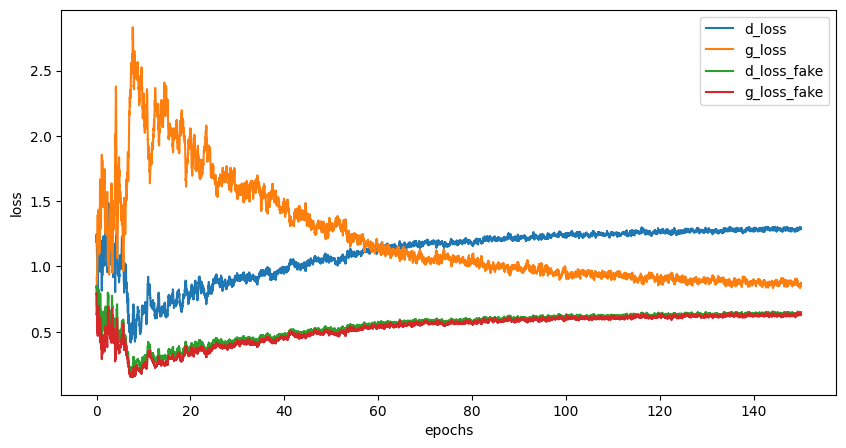

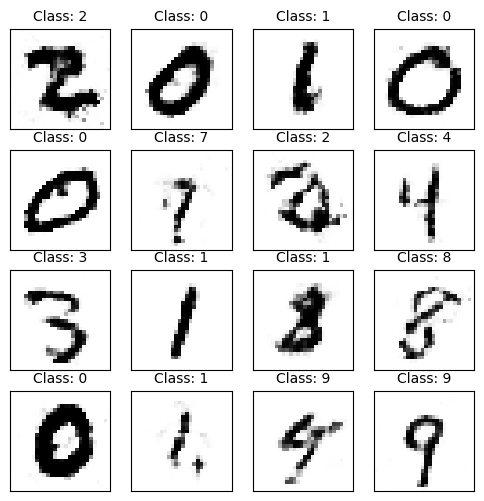

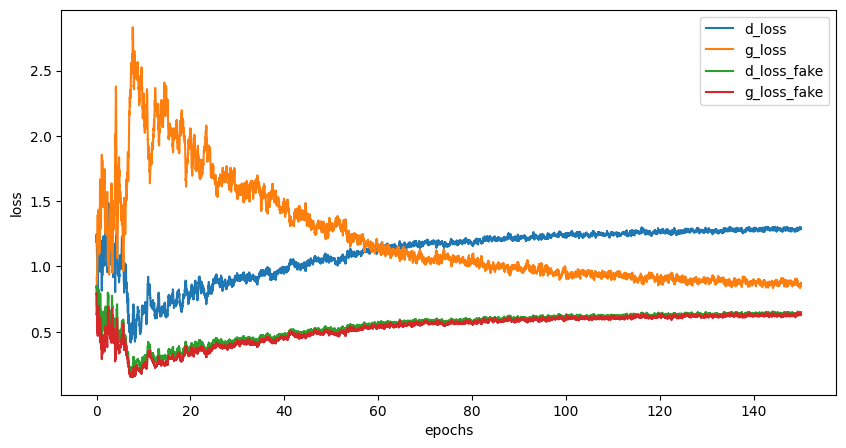

In [17]:
num_epochs = 150
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = True

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 2e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)